In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

def preprocess(image, label):
    image = tf.image.resize(image, [128,128])
    image = image / 255.0
    return image, label

BATCH_SIZE = 16

train_dataset = tfds.load('plant_village', split='train[:80%]', as_supervised=True)
train_dataset = train_dataset.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tfds.load('plant_village', split='train[80%:]', as_supervised=True)
val_dataset = val_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## check

In [4]:
print(info.features['label'].names)
print(len(info.features['label'].names))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___

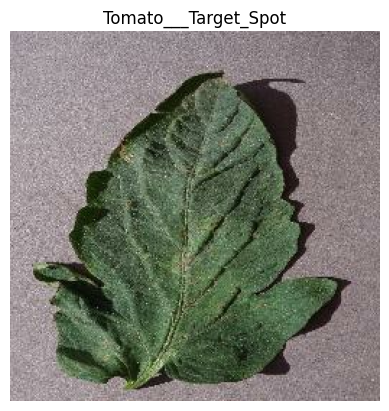

In [3]:
import matplotlib.pyplot as plt

for image, label in train_dataset.take(1):
    plt.imshow(image)
    plt.title(info.features['label'].int2str(label))
    plt.axis('off')
    plt.show()


## split data

## pre processing

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')  # 38 classes
])


In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
EPOCHS = 3

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


Epoch 1/3
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 111s 34ms/step - accuracy: 0.8119 - loss: 0.6666 - val_accuracy: 0.9307 - val_loss: 0.2162
Epoch 2/3
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.9398 - loss: 0.1794 - val_accuracy: 0.9437 - val_loss: 0.1784
Epoch 3/3
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - accuracy: 0.9565 - loss: 0.1301 - val_accuracy: 0.9390 - val_loss: 0.1948


## val

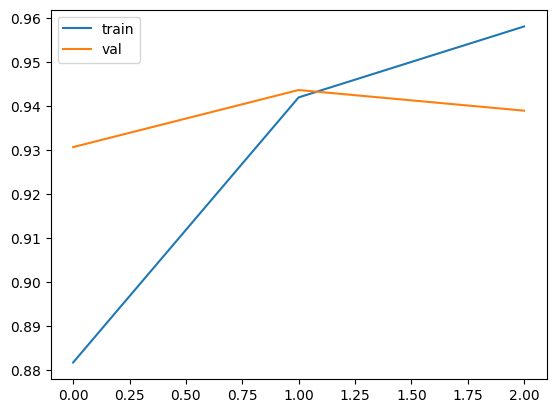

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()


In [8]:
for img, label in val_dataset.take(1):
    preds = model.predict(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [9]:
import numpy as np

pred_labels = np.argmax(preds, axis=1)
true_labels = label.numpy()


In [11]:
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
               'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew',
               'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy',
               'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
               'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)',
               'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
               'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy',
               'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch',
               'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',
               'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
               'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [class_names[i] for i in true_labels]


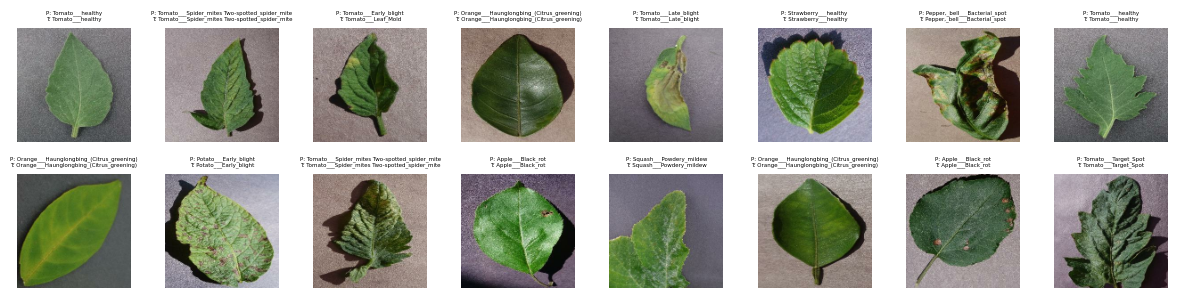

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(len(pred_class_names)):
    plt.subplot(4, 8, i+1)
    plt.imshow(img[i].numpy())
    plt.title(f"P: {pred_class_names[i]}\nT: {true_class_names[i]}", fontsize=4)
    plt.axis('off')
plt.tight_layout()
plt.show()
